In [1]:
"""
Import PyTorch libraries.
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
"""
Enable CUDA if the GPU is available
"""
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

In [ ]:
"""
Define the dataloader for the Fashion MNIST dataset.
"""
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100)
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat",
                 5: "Sandal",
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")
print(output_label(label))

NameError: name 'torchvision' is not defined

In [4]:
from re import M
"""
A Convolutional Variational Autoencoder
"""
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.flatten = nn.Flatten()

        self.econvo1 = nn.Conv2d(1, 32, 5, 1, 2)
        self.econvo2 = nn.Conv2d(32, 64, 5, 1, 2)
        self.econvo3 = nn.Conv2d(64, 64, 5, 1, 2)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.emlinear = nn.Linear(3136, 128)
        self.evlinear = nn.Linear(3136, 128)

        self.dlinear = nn.Linear(128, 49)
        self.dTconvo1 = nn.ConvTranspose2d(1, 32, 3, 2, 1, 1)
        self.dconvo1 = nn.Conv2d(32, 64, 5, 1, 2)
        self.dTconvo2 = nn.ConvTranspose2d(64, 64, 3, 2, 1, 1)

        self.dmlinear = nn.Linear(50176, 784)
        self.dvlinear = nn.Linear(50176, 784)
        self.tanh = nn.Tanh()


    def forward(self, x):
        n = x.shape[0]
        res = self.relu(self.econvo1(x))
        res = self.pool(res)
        res = self.relu(self.econvo2(res))
        res = self.pool(res)
        res = self.relu(self.econvo3(res))
        res = self.flatten(res)
        outm = self.emlinear(res)
        outv = self.evlinear(res)

        e = torch.randn_like(outv.exp())
        z = outm + outv.exp() * e

        z = self.dlinear(z)
        z = z.reshape(n, 1, 7, 7)
        z = self.relu(self.dTconvo1(z))
        z = self.relu(self.dconvo1(z))
        z = self.relu(self.dTconvo2(z))

        z = self.flatten(z)
        m = self.dmlinear(z)
        v = self.dvlinear(z)

        e = torch.randn_like(v)
        out = m + v.exp() * e

        return self.tanh(out.reshape(n, 1, 28, 28)), outm, outv

In [ ]:
"""
Initialize Hyperparameters
"""
batch_size = 128
learning_rate = 1e-3
num_epochs = 20

"""
Initialize the network and the Adam optimizer
"""
model = VAE()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

"""
Training the network for a given number of epochs
"""
def loss_func(input, result, mean, var):
    loss = F.mse_loss(result, input, reduction = "sum")
    kl = -1/2 * torch.sum(1 + var - mean ** 2 - var.exp())
    #print(f"kl: {kl.item()}, loss: {loss.item()}")
    return loss + kl
def train(model):
    model.train()
    for batch, (X, y) in enumerate(train_loader):
        img, mean, var = model(X.to(device))
        loss = loss_func(X.to(device), img, mean, var)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            print(f"batch {batch}: {loss.item()}")
for _ in range(num_epochs):
    train(model)

batch 0: 46925.50390625
batch 100: 6922.94140625
batch 200: 6620.93505859375
batch 300: 6836.93603515625
batch 400: 5502.322265625
batch 500: 3951.10595703125
batch 0: 3684.08544921875
batch 100: 3220.5029296875
batch 200: 2948.092529296875
batch 300: 2842.38427734375
batch 400: 2685.813232421875
batch 500: 2507.582763671875
batch 0: 2540.466552734375
batch 100: 2490.76806640625
batch 200: 2510.65673828125
batch 300: 2351.657958984375
batch 400: 2288.948974609375
batch 500: 2194.86767578125
batch 0: 2283.0380859375
batch 100: 2318.549072265625
batch 200: 2370.81591796875
batch 300: 2197.069091796875
batch 400: 2148.325927734375
batch 500: 2079.16943359375
batch 0: 2189.1650390625
batch 100: 2196.01611328125
batch 200: 2305.24658203125
batch 300: 2069.1640625
batch 400: 2040.7138671875
batch 500: 1974.34423828125
batch 0: 2118.529052734375
batch 100: 2086.2080078125
batch 200: 2184.979248046875
batch 300: 2011.3233642578125
batch 400: 1998.25439453125
batch 500: 1917.638671875
batch 0: 

#### Visualize the output
- Display the VAE output by generating multiple samples from the latent space.
- You can modify this function accordingly to fit your implementation.

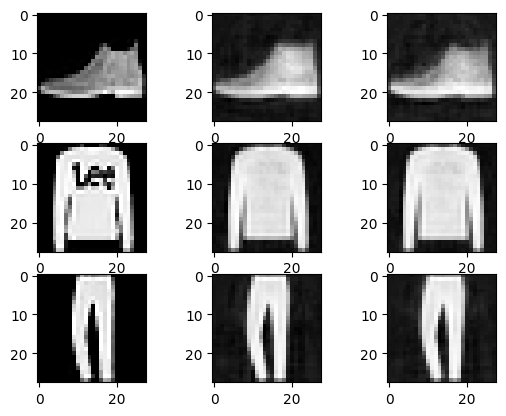

In [6]:

"""
The following part takes two images from test loader to feed into the VAE.
Both the original image and generated image(s) from the distribution are shown.
"""

import matplotlib.pyplot as plt
import numpy as np

model.eval()
with torch.no_grad():
    imgs, _ = list(test_loader)[0]
    imgs = imgs.to(device)
    fig, ax = plt.subplots(3,3)
    ax = ax.reshape(-1)
    for i in range(3):
      for j in range(3):
        if j == 0:
          # input image
          img = np.transpose(imgs[i].cpu().numpy(), [1,2,0])
          ax[i*3+j].imshow(np.squeeze(img), cmap = 'gray')
        else:
          # vae generation results
          out, mu, logVAR = model(imgs)
          outimg = np.transpose(out[i].cpu().numpy(), [1,2,0])
          ax[i*3+j].imshow(np.squeeze(outimg), cmap = 'gray')
    plt.show()


In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.linear = nn.Linear(128, 49)

        self.Tconvo1 = nn.ConvTranspose2d(1, 32, 3, 2, 1, 1)
        self.convo1 = nn.Conv2d(32, 64, 5, 1, 2)
        self.Tconvo2 = nn.ConvTranspose2d(64, 64, 3, 2, 1, 1)
        self.convo2 = nn.Conv2d(64, 1, 3, 1, 1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        n = x.shape[0]
        res = self.linear(x)
        res = res.reshape(n, 1, 7, 7)
        res = self.relu(self.Tconvo1(res))
        res = self.relu(self.convo1(res))
        res = self.relu(self.Tconvo2(res))
        res = self.convo2(res)

        return self.tanh(res)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.convo1 = nn.Conv2d(1, 32, 3, 1, 1)
        self.convo2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.convo3 = nn.Conv2d(64, 64, 3, 1, 1,)

        self.flatten = nn.Flatten()
        self.linear = nn.Linear(3136, 1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        res = self.relu(self.convo1(x))
        res = self.pool(res)
        res = self.relu(self.convo2(res))
        res = self.pool(res)
        res = self.relu(self.convo3(res))

        res = self.flatten(res)
        res = self.linear(res)
        return self.sigmoid(res)


In [14]:
"""
Initialize Hyperparameters
"""
lr = 0.0002
num_epochs = 50

generator = Generator().to(device)
discriminator = Discriminator().to(device)
goptimizer = torch.optim.Adam(generator.parameters(), lr = lr)
doptimizer = torch.optim.Adam(discriminator.parameters(), lr = lr)

"""
Initialize the network and the Adam optimizer
"""

loss_func = nn.BCELoss()

"""
Training the network for a given number of epochs
The loss after every epoch is printed
"""
def train(gen, dis, epochs):
    gloss_lst = []
    dloss_lst = []
    for epoch in range(num_epochs):
        for batch, (X, y) in enumerate(train_loader):
            n = X.shape[0]
            goptimizer.zero_grad()
            doptimizer.zero_grad()
            real_labels = torch.ones(n, 1).to(device)
            pred_real_labels = dis(X.to(device))
            rdloss = loss_func(pred_real_labels, real_labels)

            z = torch.randn(n, 128).to(device)
            with torch.no_grad():
                fake_imgs = gen(z)

            pred_fake_labels = dis(fake_imgs)
            fake_labels = torch.zeros(n, 1).to(device)
            fdloss = loss_func(pred_fake_labels, fake_labels)
            (rdloss + fdloss).backward()

            doptimizer.step()

            fake_imgs = gen(z)
            pred_fake_labels = dis(fake_imgs)
            gloss = loss_func(pred_fake_labels, real_labels)
            gloss.backward()

            goptimizer.step()

            dloss_lst.append((fdloss + rdloss).item())
            gloss_lst.append(gloss.item())
            if batch % 100 == 0:
                print(f"\tbatch {batch}: gen loss: {gloss.item()}, dis loss {(rdloss + fdloss).item()}")
        print(f"EPOCH {epoch}: gen loss: {gloss.item()}, dis loss{(rdloss + fdloss).item()}")
    return gloss_lst, dloss_lst

gloss, dloss = train(generator, discriminator, num_epochs)


	batch 0: gen loss: 0.6793478727340698, dis loss 1.379106044769287
	batch 100: gen loss: 2.425450325012207, dis loss 0.18957401812076569
	batch 200: gen loss: 4.500707149505615, dis loss 0.12415610253810883
	batch 300: gen loss: 7.322149276733398, dis loss 0.0006834196392446756
	batch 400: gen loss: 8.311544418334961, dis loss 0.0002480463299434632
	batch 500: gen loss: 9.200668334960938, dis loss 0.00010815272980835289
EPOCH 0: gen loss: 0.7583776712417603, dis loss3.026510715484619
	batch 0: gen loss: 0.9310429096221924, dis loss 3.348646402359009
	batch 100: gen loss: 2.167548179626465, dis loss 0.3341939449310303
	batch 200: gen loss: 2.749263048171997, dis loss 0.2660873532295227
	batch 300: gen loss: 2.9934611320495605, dis loss 0.33013901114463806
	batch 400: gen loss: 1.2291276454925537, dis loss 0.7880004644393921
	batch 500: gen loss: 1.895076870918274, dis loss 0.43670225143432617
EPOCH 1: gen loss: 2.154787540435791, dis loss0.47893741726875305
	batch 0: gen loss: 2.3637213

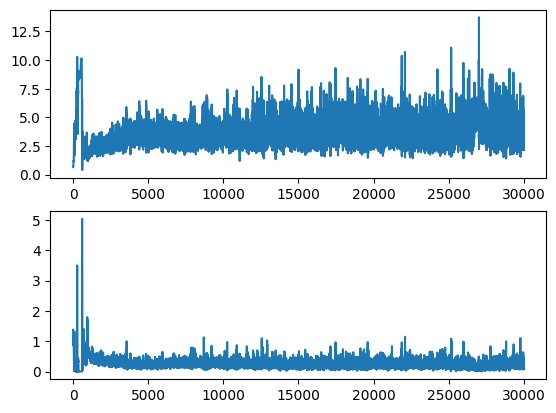

In [15]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1)

ax[0].plot(gloss)
ax[1].plot(dloss)
plt.show()

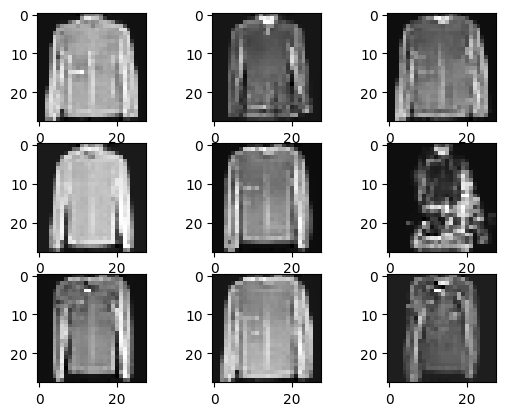

In [19]:
fig, ax = plt.subplots(3,3)
ax = ax.reshape(-1)
z = torch.randn(9, 128).to(device)
fake = generator(z)

for i in range(9):
  ax[i].imshow(fake[i,0].cpu().data.numpy(), cmap = 'gray')
plt.show()